In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Solution to exercise 5: Simple Hay et al. model neuron simulation with one synaptic input

Move downwards and follow instructions to see solutions to various tasks:

In [2]:
import os
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import neuron
import LFPy
from hay_model.hay_active_declarations import active_declarations
h = neuron.h

In [3]:
# the following will attempt to convert NEURON NMODL (.mod) files into C-language files and 
# compile them. This step requires the correct C-compiler, which may depend on your system and 
# python (conda) environment and the manner in which NEURON and LFPy was installed. 
# 
# If you encounter errors, contact the tutor(s) for some technical assistance. 
retval = os.getcwd()
print("Current working directory %s" % retval)
os.chdir(join("hay_model", "mod"))
!nrnivmodl
os.chdir(retval)

Current working directory /home/tone/teaching/Exercise 5
/home/tone/teaching/Exercise 5/hay_model/mod
Mod files: "./CaDynamics_E2.mod" "./Ca_HVA.mod" "./Ca_LVAst.mod" "./Ih.mod" "./Im.mod" "./K_Pst.mod" "./K_Tst.mod" "./Nap_Et2.mod" "./NaTa_t.mod" "./NaTs2_t.mod" "./SK_E2.mod" "./SKv3_1.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


In [4]:
neuron.load_mechanisms(join("hay_model", 'mod'))

True

In [5]:
def return_cell(synaptic_y_pos=900, 
                conductance_type='active', 
                weight=0.001, 
                input_spike_train=np.array([10.])):
    """
    Runs a NEURON simulation and returns an LFPy cell object for a single synaptic input.
    :param synaptic_y_pos: position along the apical dendrite where the synapse is inserted.
    :param conductance_type: Either 'active' or 'passive'. 
           If 'active' all original ion-channels are included,
           if 'passive' they are all removed, yielding a passive cell model.
    :param weight: Strength of synaptic input.
    :param input_spike_train: Numpy array containing synaptic spike times
    :return: cell object where cell.imem gives transmembrane currents, 
             cell.vmem gives membrane potentials.
             See LFPy documentation for more details and examples.
    """
    h('forall delete_section()')
    model_path = 'hay_model'
    #neuron.load_mechanisms(join(model_path, 'mod'))
    cell_parameters = {
        'morphology': join(model_path, 'cell1.hoc'),
        'v_init': -65,
        'passive': False,
        'nsegs_method': 'lambda_f',
        'lambda_f': 100,
        'dt': 2**-3,  # Should be a power of 2
        'tstart': -200,
        'tstop': 200,
        'custom_code': [join(model_path, 'custom_codes.hoc')],
        'custom_fun': [active_declarations],
        'custom_fun_args': [{'conductance_type': conductance_type}],
    }
    cell = LFPy.Cell(**cell_parameters)
    synapse_parameters = {
        # Returns compartment on cell closest to coordinates:
        'idx': cell.get_closest_idx(x=0., y=synaptic_y_pos, z=0.),  
        'e': 0.,
        'syntype': 'ExpSyn',
        'tau': 10.,
        'weight': weight,
        'record_current': True,
    }
    synapse = LFPy.Synapse(cell, **synapse_parameters)
    synapse.set_spike_times(input_spike_train)
    cell.simulate(rec_imem=True, rec_vmem=True)
    cell.strip_hoc_objects()  # fix crashing kernels with neuron.__version__ >= 7.8
    return cell

In [6]:
def plot_cell(cell):
    cell_plot_idx = 0
    fig = plt.figure(figsize=(12, 8))
    fig.subplots_adjust(hspace=0.5)  # Adjusts the vertical distance between panels.
    
    ax1 = fig.add_subplot(121, aspect=1, xticks=[], xlabel='x [µm]', ylabel='y [µm]')
    ax1.plot(cell.x.T, cell.y.T, c='k')
    ax1.plot(cell.x.mean(axis=-1)[cell.synidx], cell.y.mean(axis=-1)[cell.synidx], 'ro')
    
    ax2 = fig.add_subplot(222, title='Membrane potential', xlabel='Time [ms]', ylabel='mV')
    ax2.plot(cell.tvec, cell.vmem[cell_plot_idx, :])
    
    ax3 = fig.add_subplot(224, title='Transmembrane currents', xlabel='Time [ms]', ylabel='nA')
    ax3.plot(cell.tvec, cell.imem[cell_plot_idx, :])
    plt.savefig('exercise_5_1.png')

In [7]:
def return_soma_v_line(cell, axes, dist):
    cell_plot_idx = 0
    sig_shifted = (cell.vmem[cell_plot_idx, :] - cell.vmem[cell_plot_idx, 0])
    axes[0].plot(cell.tvec, sig_shifted/np.max(sig_shifted), label='%d µm' % dist)
    axes[1].plot(cell.tvec, cell.vmem[cell_plot_idx, :], label='%d µm' % dist)

In [8]:
def plot_v_response_with_distance(conductance_type="active"):
    distances = np.linspace(0, 1200, 5)
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(121, ylim=[-0.2, 1.2])
    ax2 = fig.add_subplot(122, ylim=[-65.2, -64])
    for dist in distances:
        cell = return_cell(dist, conductance_type)
        return_soma_v_line(cell, [ax1, ax2], dist)
    plt.legend()
    plt.savefig('exercise_5_2_%s.png' % conductance_type)

In [9]:
def coincidence_detection(conductance_type):
    #input_spike_train = np.array([20, 50, 80])
    input_spike_train = np.array([20, 60, 100])

    cell = return_cell(conductance_type=conductance_type, 
                       input_spike_train=input_spike_train, 
                       synaptic_y_pos=1100)
    input_idx = cell.synidx[0]
    soma_idx = 0
    fig = plt.figure(figsize=(12, 8))

    fig.text(0.5, 0.95, conductance_type.capitalize() + ' conductances', ha='center', size=17)
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    ax1 = fig.add_subplot(121, aspect=1)
    ax1.plot(cell.x.T, cell.y.T, c='k')
    # [plot([cell.xstart[idx], cell.xend[idx]], [cell.ystart[idx], cell.yend[idx]], c='k') 
    #  for idx in range(cell.totnsegs)]
    ax1.plot(cell.x.mean(axis=-1)[cell.synidx], cell.y.mean(axis=-1)[cell.synidx], 'ro')

    ax2 = fig.add_subplot(222, title='Input\nmembrane potential', ylim=[-70, -35])
    ax2.plot(cell.tvec, cell.vmem[input_idx, :])

    ax3 = fig.add_subplot(224, title='Soma\nmembrane potential', ylim=[-65.02, -64.6])
    ax3.plot(cell.tvec, cell.vmem[soma_idx, :])
    plt.savefig('exercise_5_3_%s.png' % conductance_type)
    print(input_idx)

__(i)__ For the simplest example of a single spike:

active ion-channels inserted.


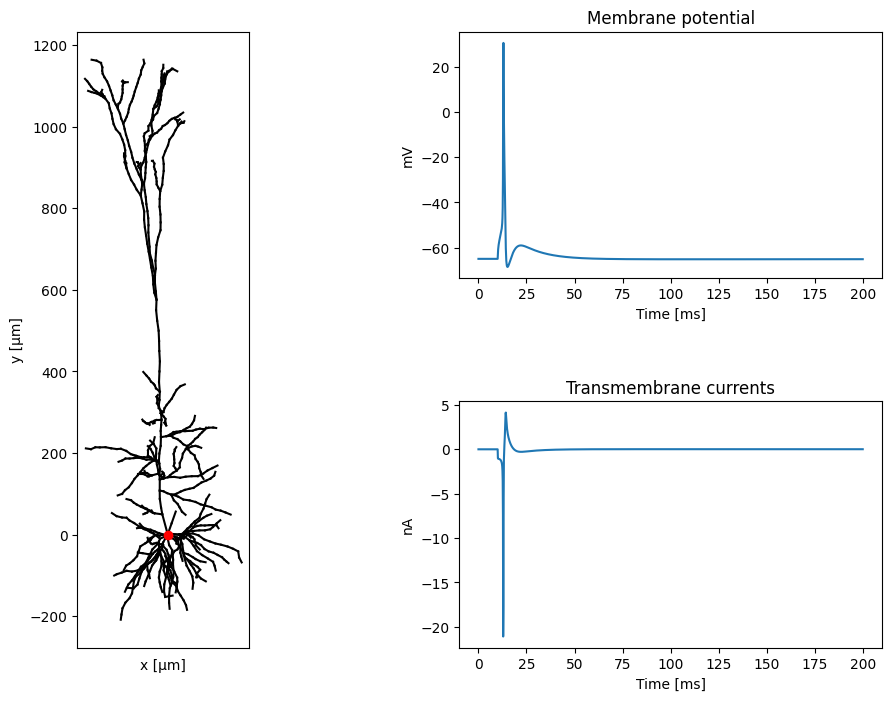

In [10]:
cell = return_cell(conductance_type='active', weight=0.02, synaptic_y_pos=0)
plot_cell(cell)

__(ii)__ To see the somatic response to incrementally more distant apical synaptic input execute the block below. We note that the width of the synaptic response increases with distance.

active ion-channels inserted.
active ion-channels inserted.
active ion-channels inserted.
active ion-channels inserted.
active ion-channels inserted.


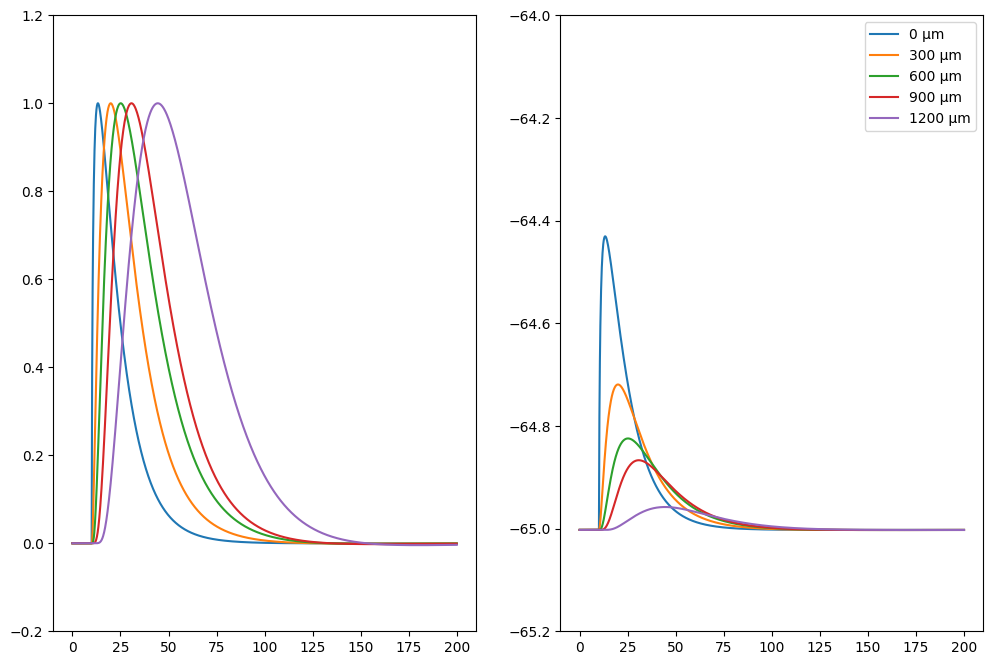

In [11]:
plot_v_response_with_distance()

__(iii)__ For coincidence detection in a passive neuron, run the first cell below, and for an active neuron, run the second cell. Comparing the cases will show that when three consecutive spikes arrives at a synapse (marked by red dot on morphology) with an inter-spike interval of 40 ms, the membrane potential in the compartment where the input arrives has three distict peak. For the passive model, these inputs are seen to sum a single wide and smeared potential-hump in the soma compartment due to temporal summation and filtering by the passive dendrites. For the case with active conductances this is somewhat different, and the voltage response in the soma has similar temporal width as at the compartment where the spike input arrives. Thus the active conductances compensate for the temporal blurring imposed by the passive dendrites and 'sharpens' up the signal. In this way the active conductances makes the cell more sensitive to detecting coincident synaptic inputs, and it has been speculated that this is the primary role of the IH current (References: Migliore M, Messineo L, Ferrante M (2004): Dendritic Ih selectively blocks temporal summation of unsynchronized distal inputs in CA1 pyramidal neurons. J Comput Neurosci 16: 5-13; Vaidya SP, Johnston D (2013) Temporal synchrony and gamma-to-theta power conversion in the dendrites of CA1 pyramidal neurons. Nat Neurosci 16: 1812-1820.)

Passive dynamics inserted.
860


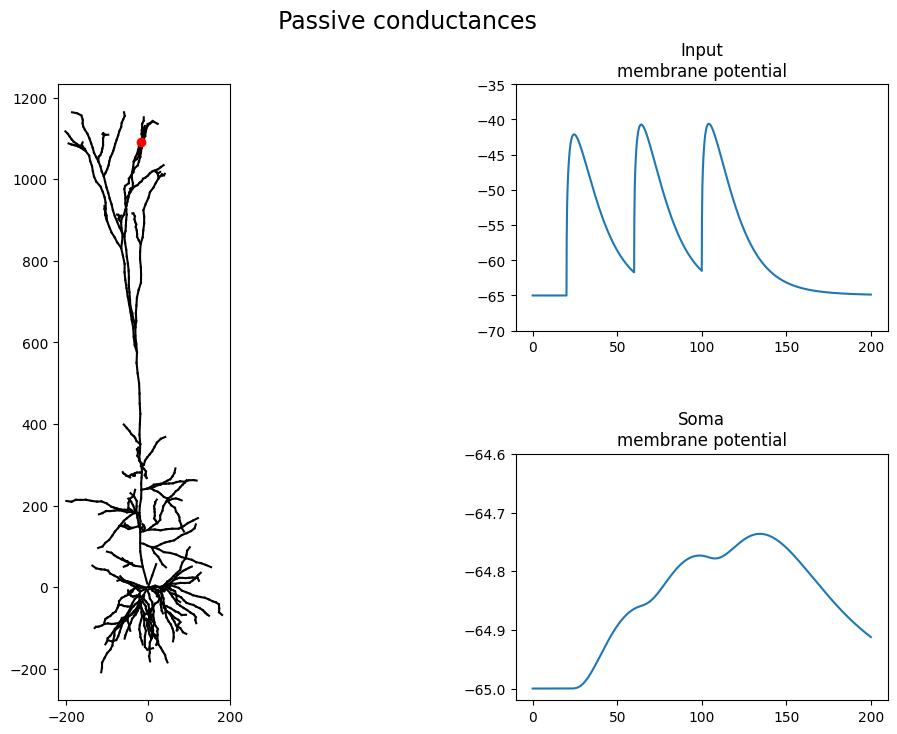

In [12]:
coincidence_detection('passive')

active ion-channels inserted.
740


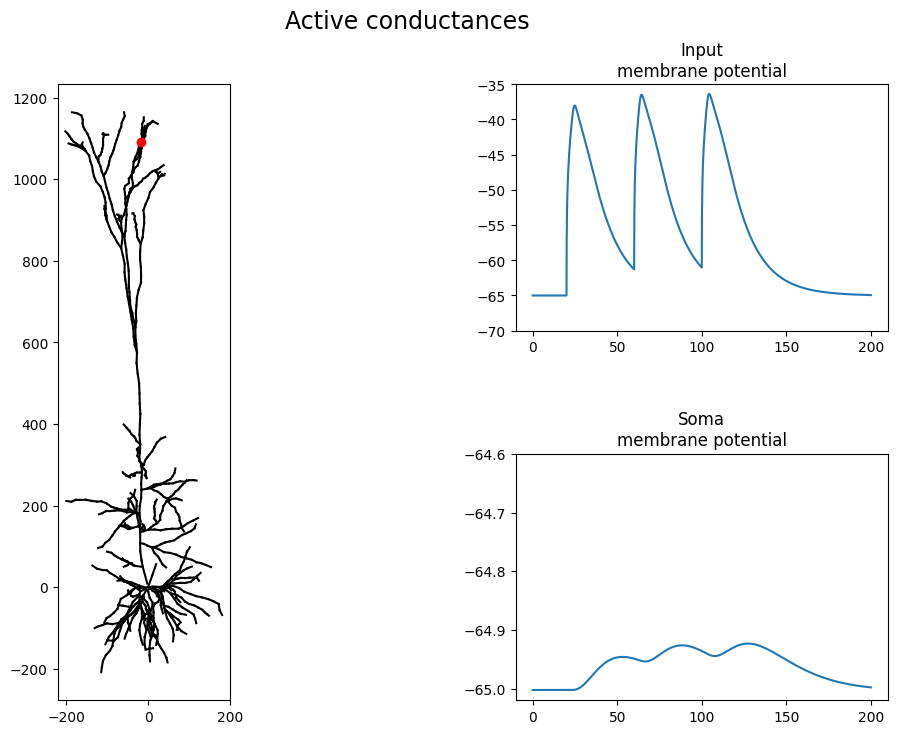

In [13]:
coincidence_detection('active')